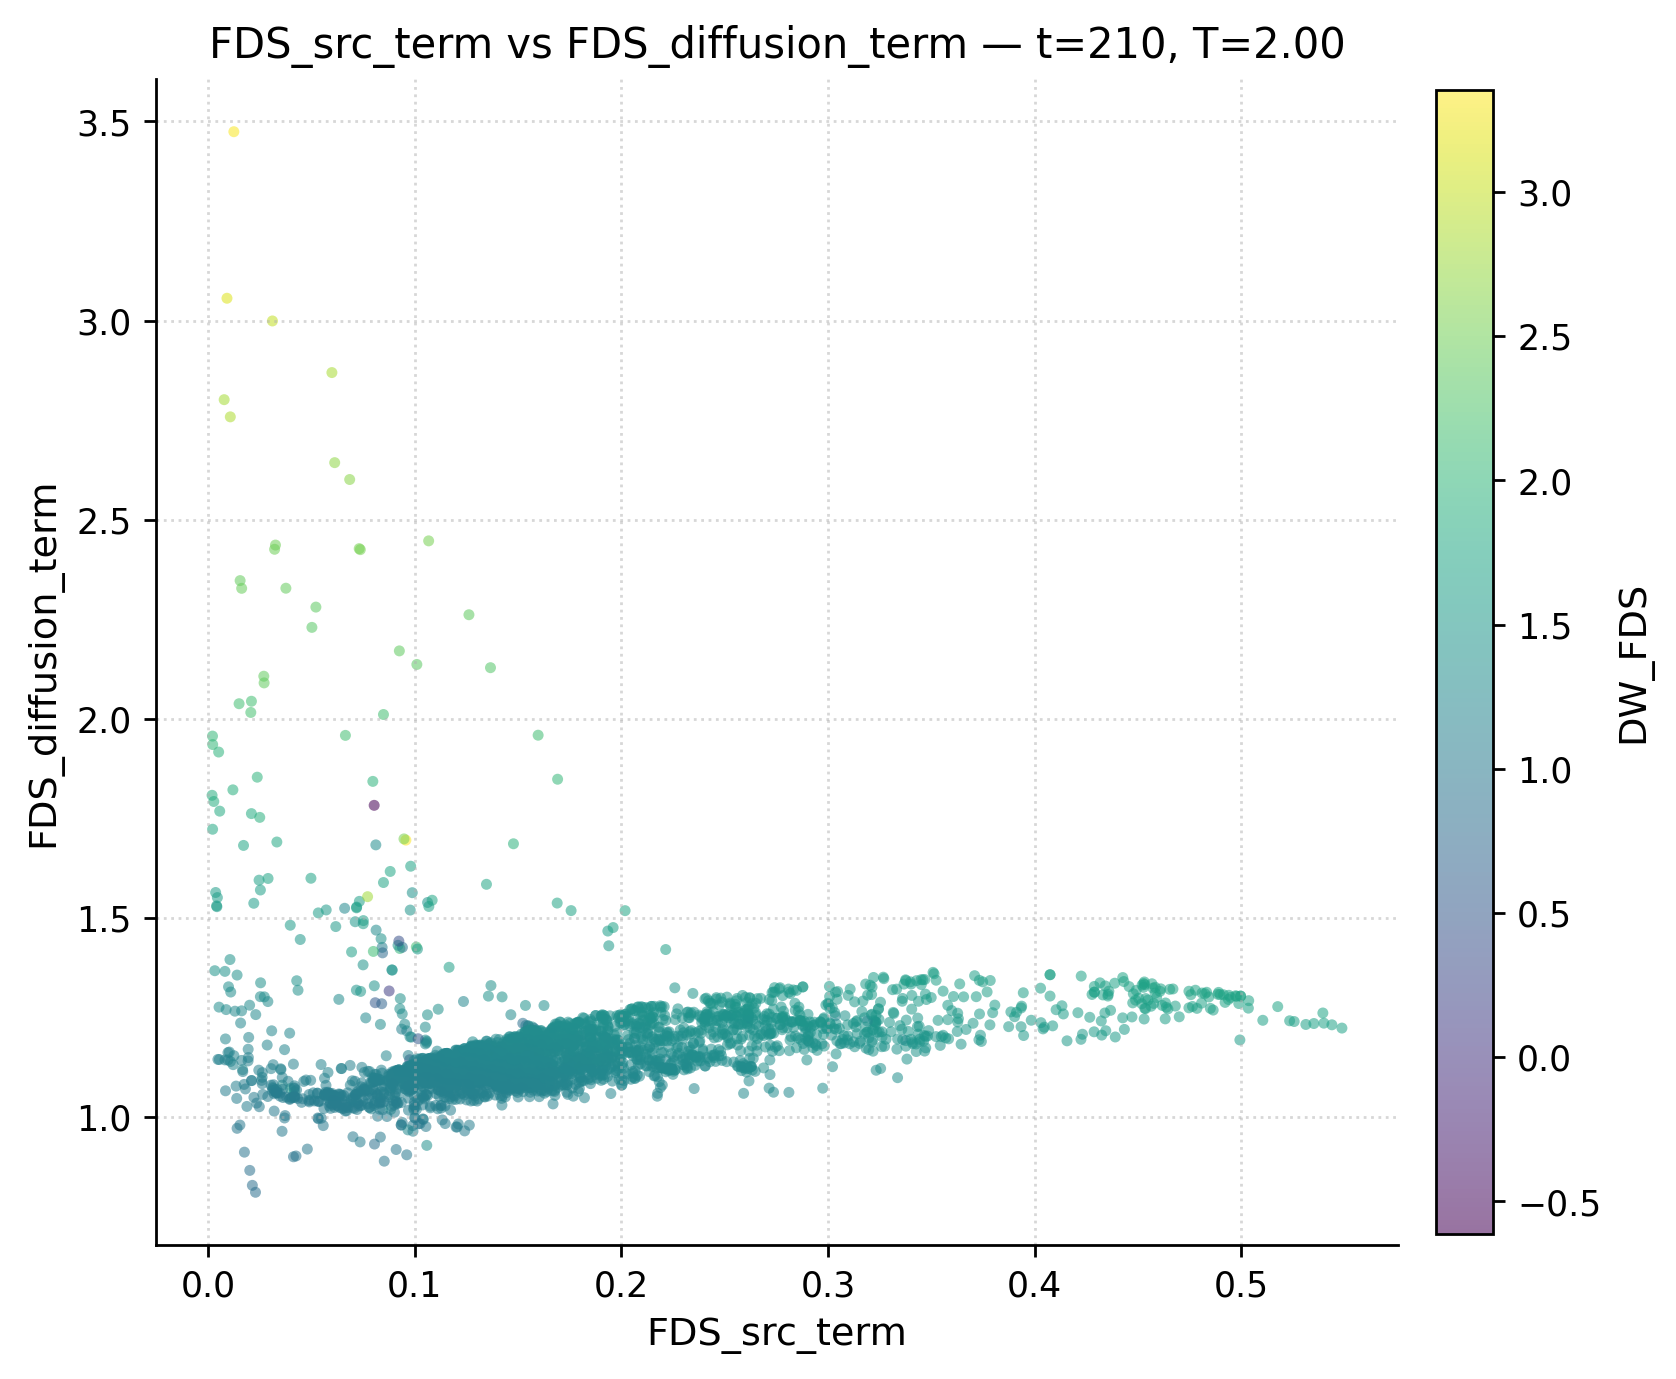

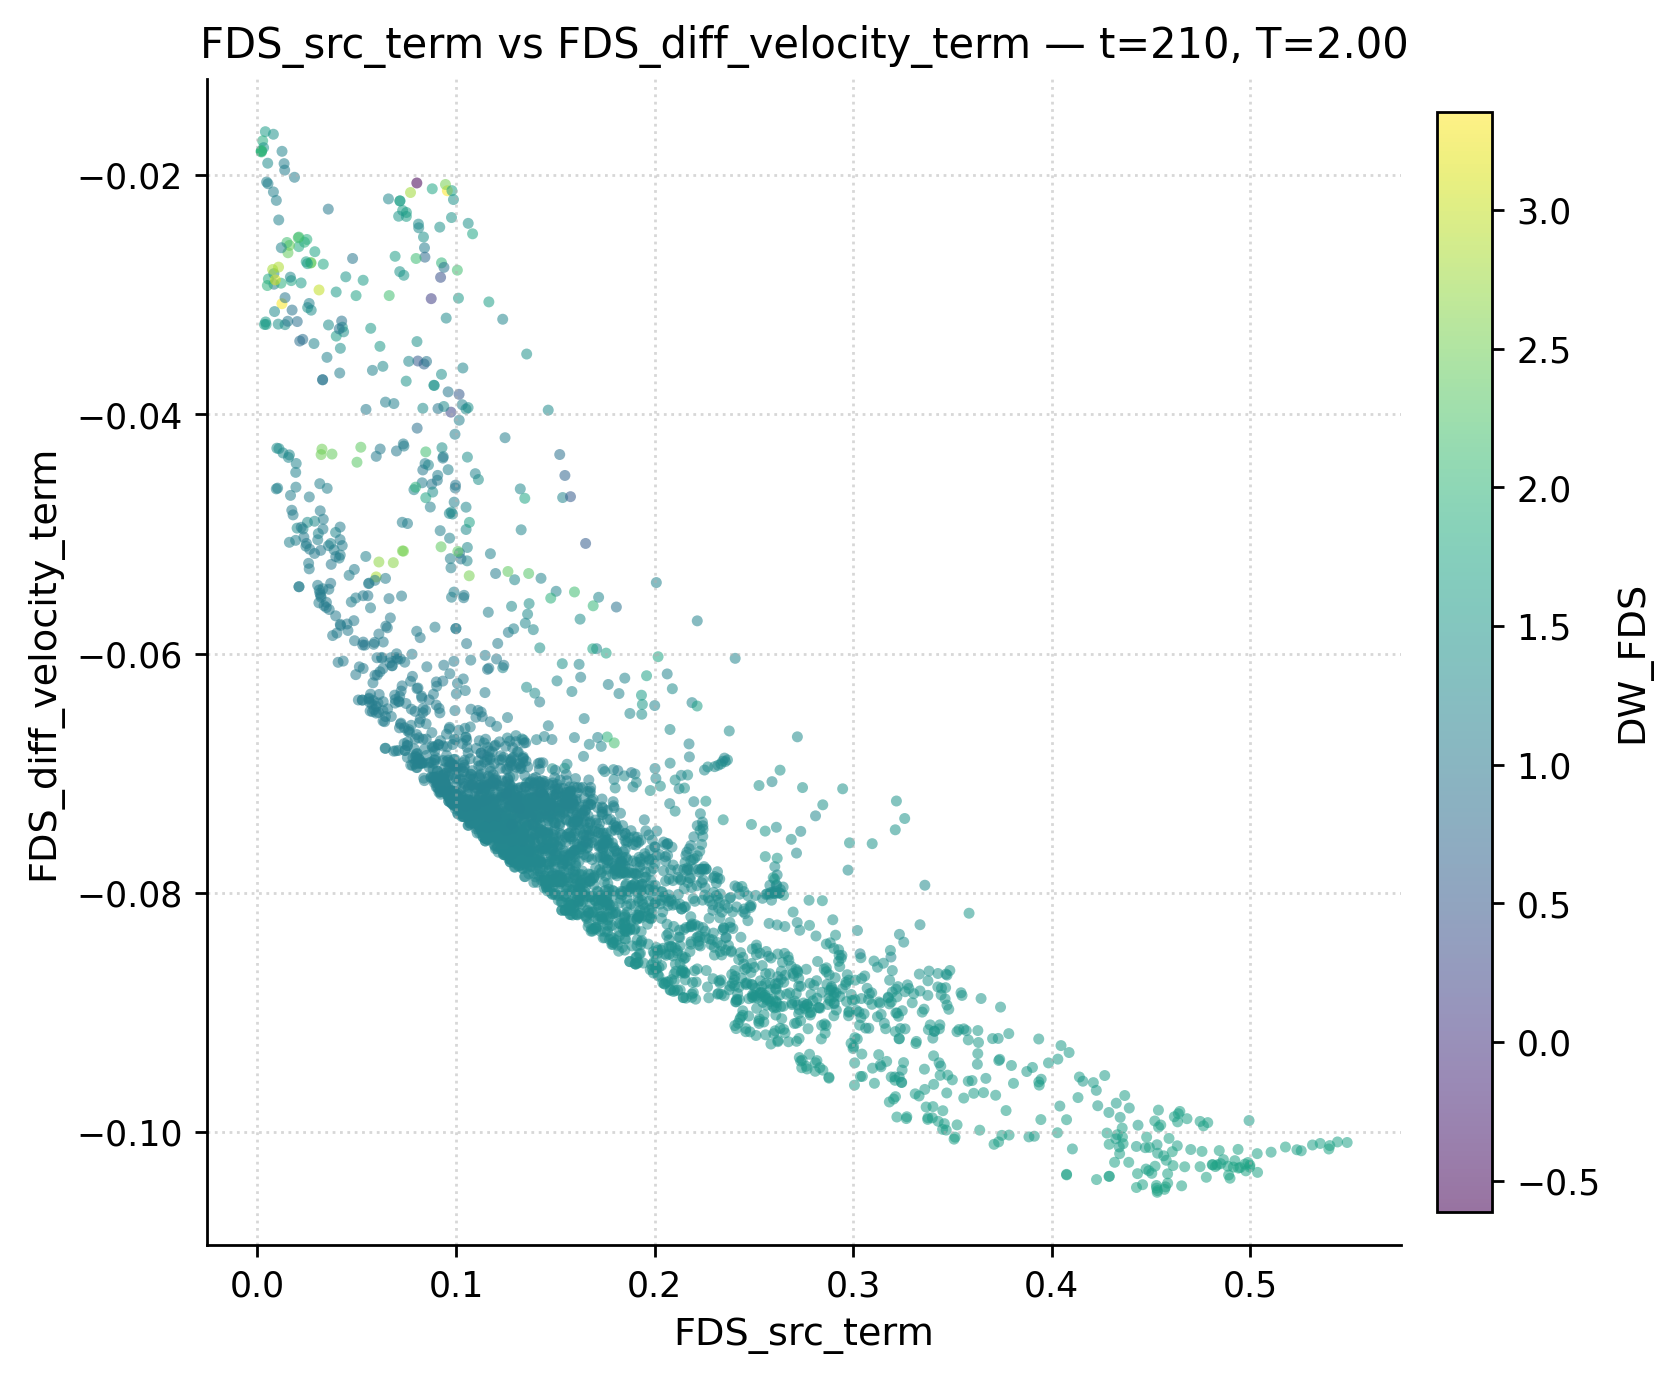

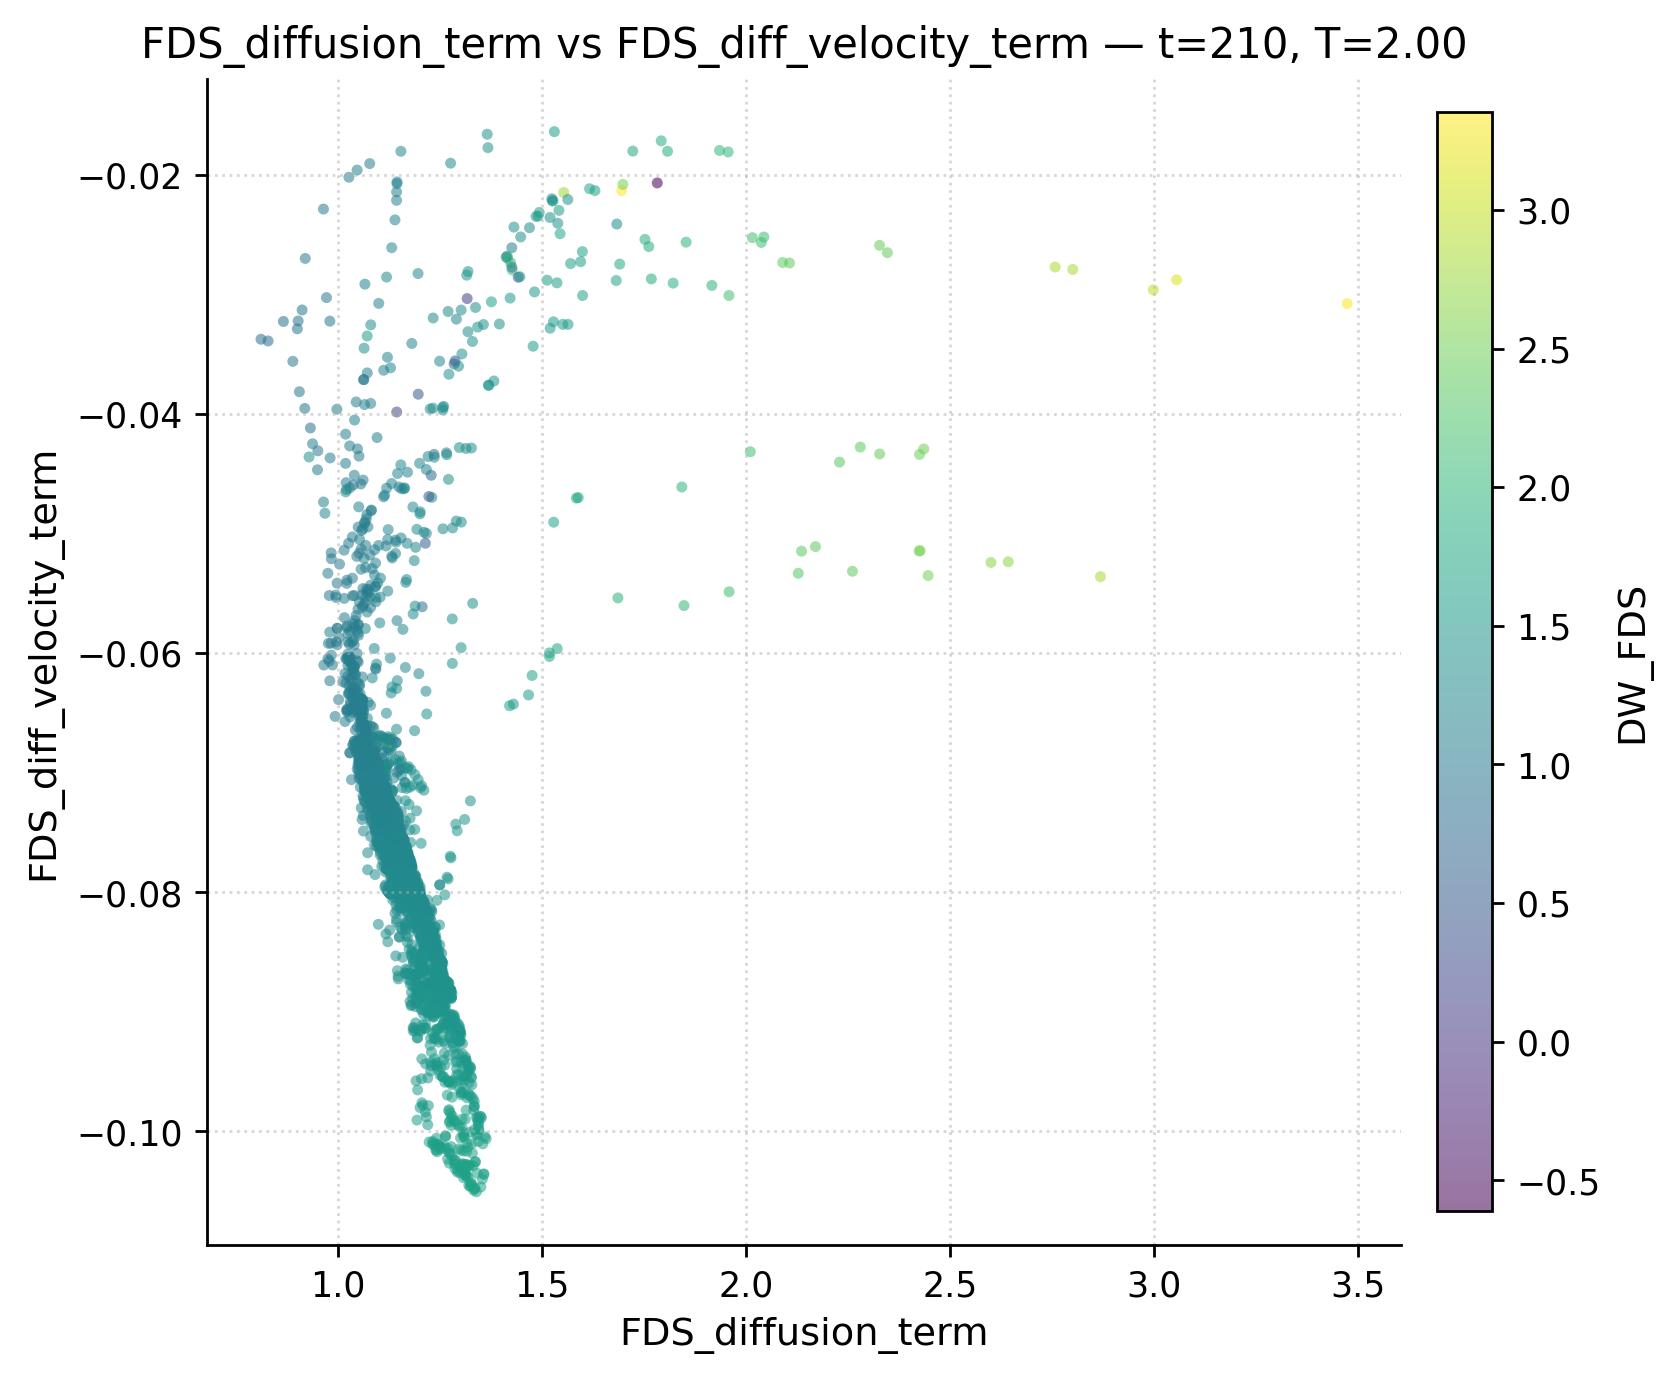

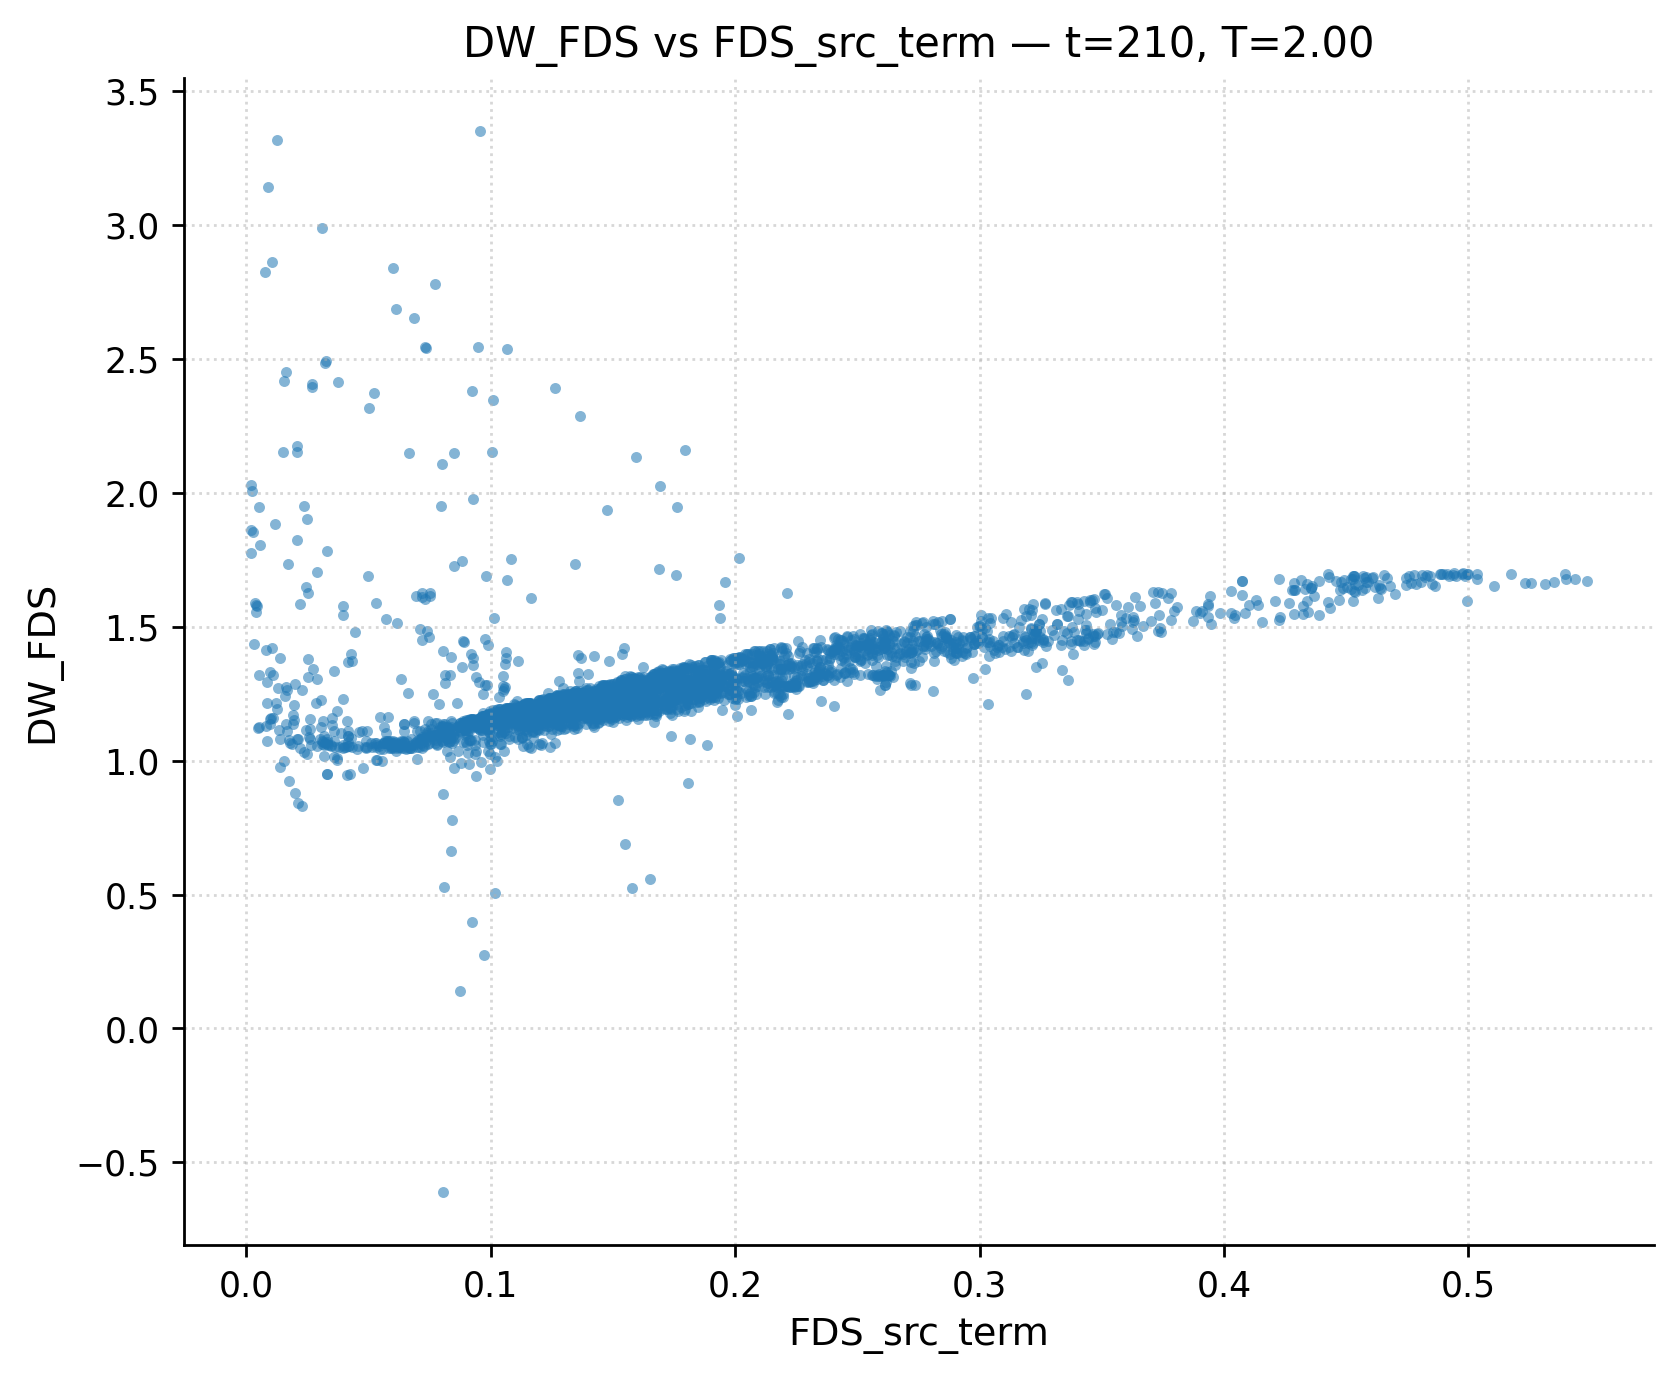

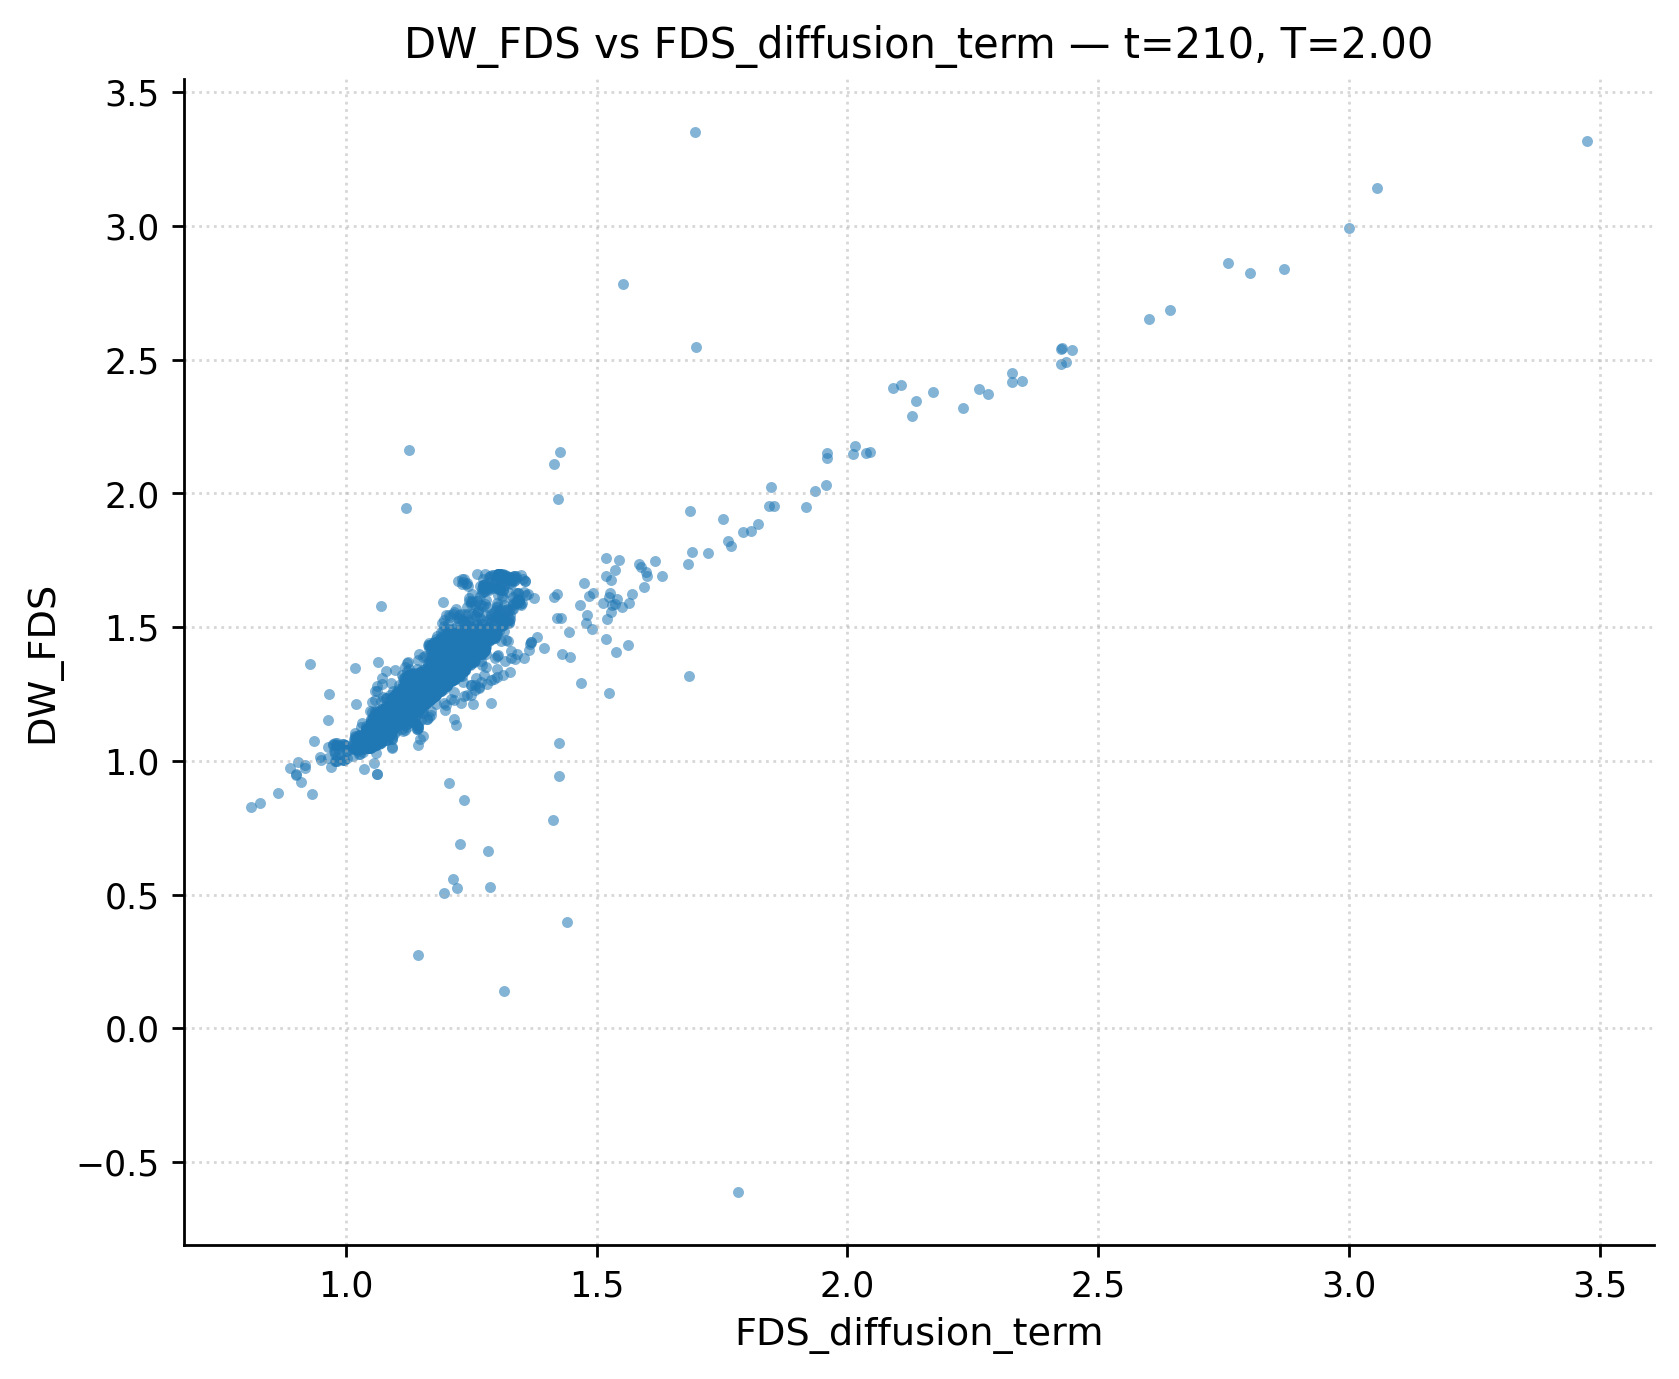

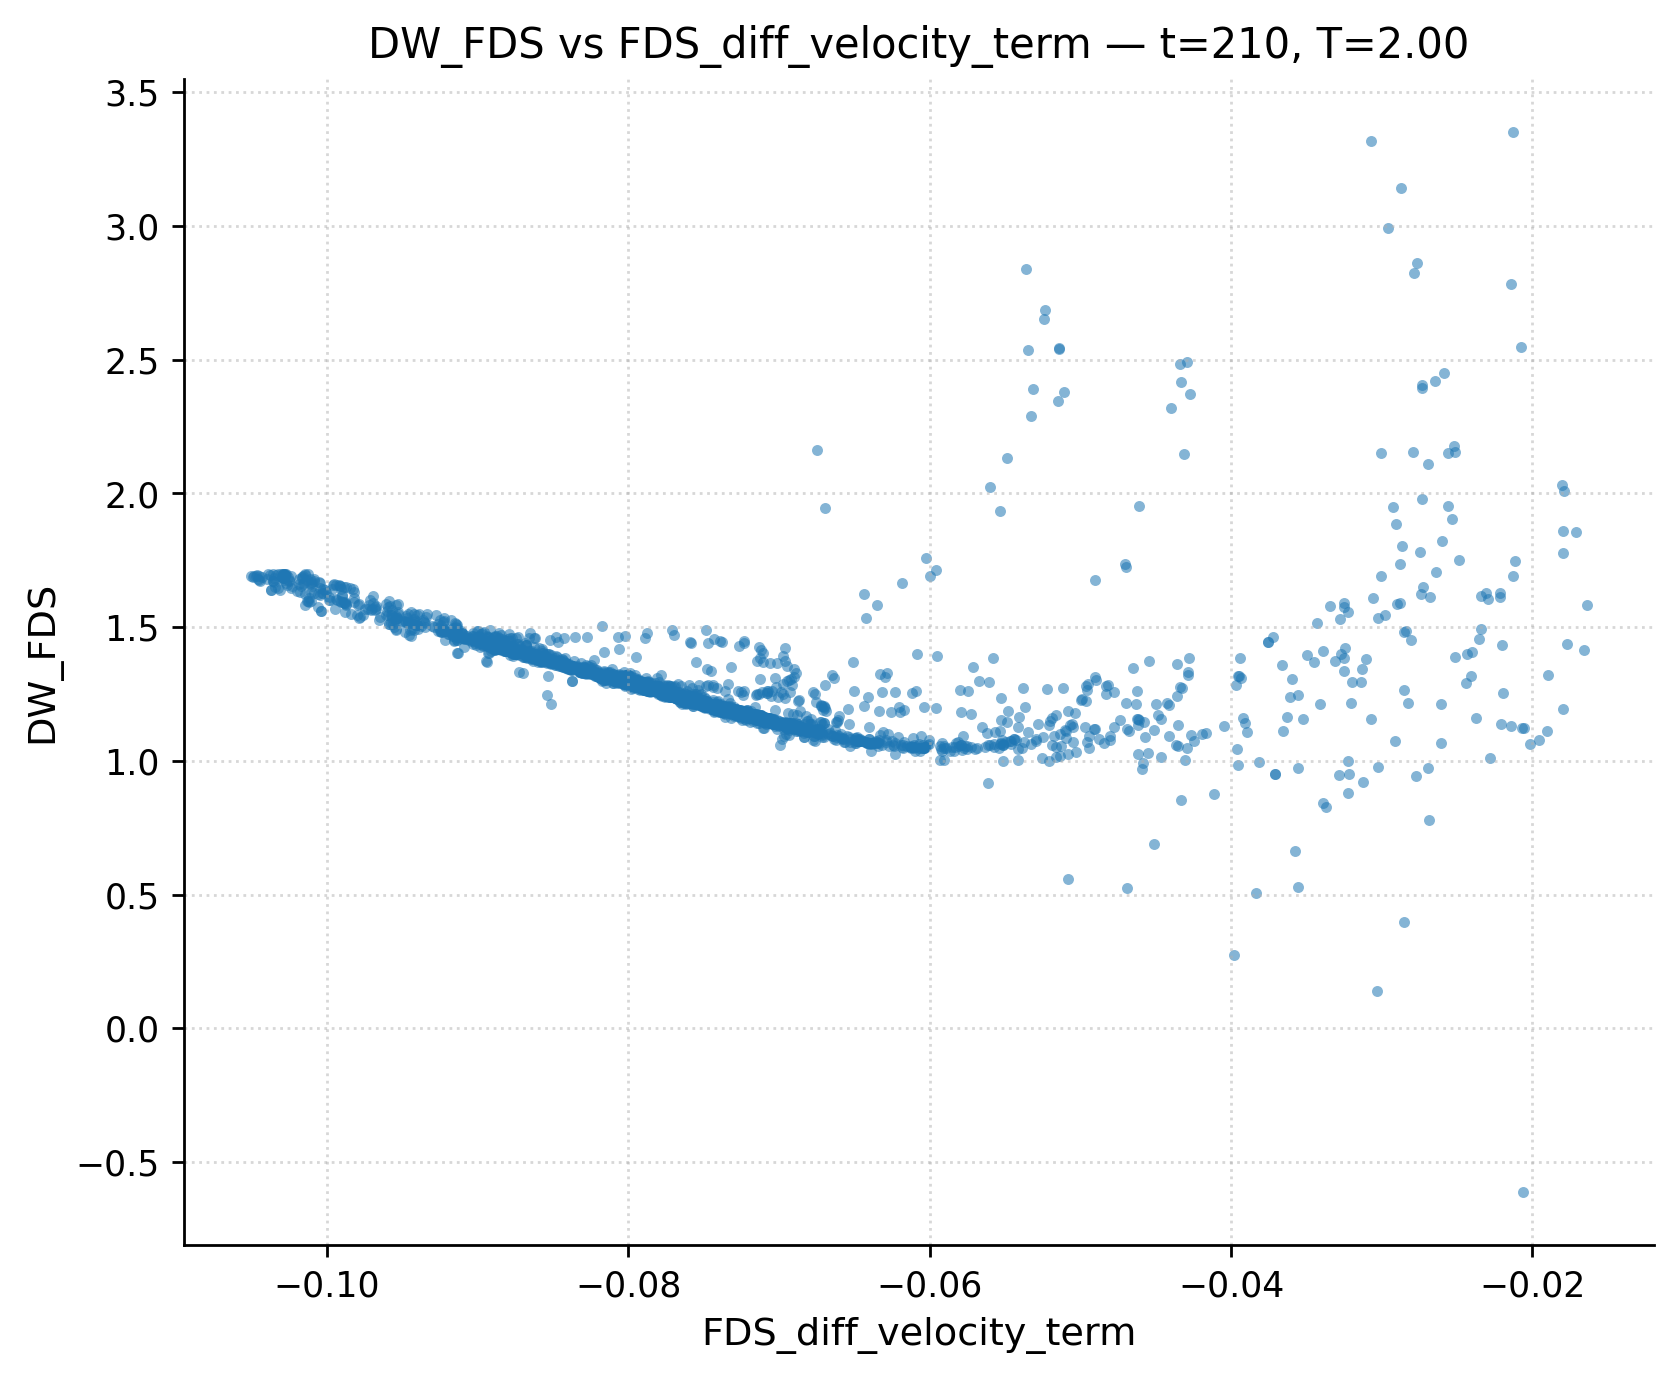

In [8]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flamekit.io_fronts import Case, load_fronts

# ============================================================
# USER SETTINGS
# ============================================================
PHI = 0.40
LAT_SIZE = "100"
TIME_STEPS = [210]                 # add more: e.g. [200, 205, 210, 211]
ISOLEVELS = [2.0]

BASE_DIR = Path("../isocontours")
POST = True

# Optional Case fields (only used if your Case supports them)
MULTIPLE_RUNS = False
N_RUN = 2
SORET_TERM = False
SORET_POSITIVE = False

# Features and target
TERMS = ["FDS_src_term", "FDS_diffusion_term", "FDS_diff_velocity_term"]
TARGET = "DW_FDS"

# Plot controls
FIG_DPI = 250
SCATTER_S = 10
ALPHA = 0.55
RASTERIZE = True

# Color cross-plots by DW_FDS (recommended)
COLOR_CROSS_BY_TARGET = True

# Minimum samples to plot
MIN_SAMPLES = 100

# Save figures
SAVE_FIGS = True
OUT_BASE_DIR = Path(r"C:\Users\alexp\Documents\Bachelor Thesis\report_figures\results\FDS_decomposition_analysis")

# Filenames (no clustering)
CROSS_FNAME_FMT = "cross__{f1}__vs__{f2}.png"
DWVS_FNAME_FMT = "dw_vs__DW_FDS__vs__{feat}.png"

# ============================================================
# MATPLOTLIB DEFAULTS (quality)
# ============================================================
plt.rcParams.update({
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ============================================================
# HELPERS
# ============================================================
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN,
            soret_term=SORET_TERM,
            soret_positive=SORET_POSITIVE,
        )
    except TypeError:
        return Case(**base_kwargs)


def make_out_dir(lat_size: str, time_step: int, c_val: float) -> Path:
    # Keep same folder naming convention
    return OUT_BASE_DIR / f"h_{lat_size}_t_{time_step}_T_{c_val:g}"


def require_columns(df: pd.DataFrame, cols: list[str], context: str = "") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{context} Missing columns: {missing}")


def clean_valid_rows(df: pd.DataFrame, cols_needed: list[str]) -> pd.DataFrame:
    valid = df[cols_needed].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return df.loc[valid.index].copy()


def save_or_show(fig, savepath: Path | None):
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, dpi=FIG_DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)


def plot_cross_scatter(df: pd.DataFrame, f1: str, f2: str, title: str,
                       savepath: Path | None = None, color_by: str | None = None) -> None:
    fig, ax = plt.subplots(figsize=(6.6, 5.4), dpi=FIG_DPI, constrained_layout=True)

    if color_by is None:
        ax.scatter(df[f1], df[f2], s=SCATTER_S, alpha=ALPHA, linewidths=0, rasterized=RASTERIZE)
    else:
        sc = ax.scatter(df[f1], df[f2], c=df[color_by], s=SCATTER_S, alpha=ALPHA,
                        linewidths=0, rasterized=RASTERIZE)
        cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label(color_by)

    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(title)
    ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.5)

    save_or_show(fig, savepath)


def plot_target_vs_feature(df: pd.DataFrame, feat: str, title: str,
                           savepath: Path | None = None) -> None:
    fig, ax = plt.subplots(figsize=(6.6, 5.4), dpi=FIG_DPI, constrained_layout=True)

    ax.scatter(df[feat], df[TARGET], s=SCATTER_S, alpha=ALPHA, linewidths=0, rasterized=RASTERIZE)

    ax.set_xlabel(feat)
    ax.set_ylabel(TARGET)
    ax.set_title(title)
    ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.5)

    save_or_show(fig, savepath)


# ============================================================
# RUN
# ============================================================
pairs = [
    (TERMS[0], TERMS[1]),
    (TERMS[0], TERMS[2]),
    (TERMS[1], TERMS[2]),
]

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, ISOLEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        require_columns(front, TERMS + [TARGET], context=f"t={t}, ISO {c_val}:")
        out_dir = make_out_dir(LAT_SIZE, t, float(c_val))
        if SAVE_FIGS:
            out_dir.mkdir(parents=True, exist_ok=True)

        # Valid rows for both cross-plots and DW-vs-feature plots
        dfv = clean_valid_rows(front, TERMS + [TARGET])

        if len(dfv) < MIN_SAMPLES:
            print(f"t={t}, T={float(c_val):.2f}: skipped (n={len(dfv)} < {MIN_SAMPLES})")
            continue

        # --------------------------
        # 1) Pairwise cross-plots
        # --------------------------
        for f1, f2 in pairs:
            fname = CROSS_FNAME_FMT.format(f1=f1, f2=f2)
            savepath = (out_dir / fname) if SAVE_FIGS else None
            plot_cross_scatter(
                dfv,
                f1=f1,
                f2=f2,
                title=f"{f1} vs {f2} — t={t}, T={float(c_val):.2f}",
                savepath=savepath,
                color_by=(TARGET if COLOR_CROSS_BY_TARGET else None),
            )

        # --------------------------
        # 2) DW_FDS vs each term
        # --------------------------
        for feat in TERMS:
            fname = DWVS_FNAME_FMT.format(feat=feat)
            savepath = (out_dir / fname) if SAVE_FIGS else None
            plot_target_vs_feature(
                dfv,
                feat=feat,
                title=f"{TARGET} vs {feat} — t={t}, T={float(c_val):.2f}",
                savepath=savepath,
            )
